# ARIMA and SARIMA on Stock Price Data

### Function to Check Stationarity Using Augmented Dickey-Fuller Test:

In [12]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_result(series):
    """
    Function To Perform Augmenter Dickey-Fuller Test and Display Results.
    """
    
    result= adfuller(series.dropna())
    
    labels = ["Test Statistics", "p-Value", "No. of Lags", "No. of Observations"]
    
    output = pd.Series(result[0:4], index= labels)
    
    for key,value in result[4].items():
        output[f"Critical Value {key}"] = value
        
    print(output)
    
    print("\n")
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [2]:
import numpy as np
import pandas as pd

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

from sklearn.metrics import mean_squared_error

In [3]:
df= pd.read_csv("stock_price.csv", index_col= 0, parse_dates= True)

In [4]:
df.head()

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [5]:
df.index

DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='ds', length=204, freq=None)

In [6]:
df.index.freq = "MS"

In [7]:
df.index

DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='ds', length=204, freq='MS')

<AxesSubplot:xlabel='ds'>

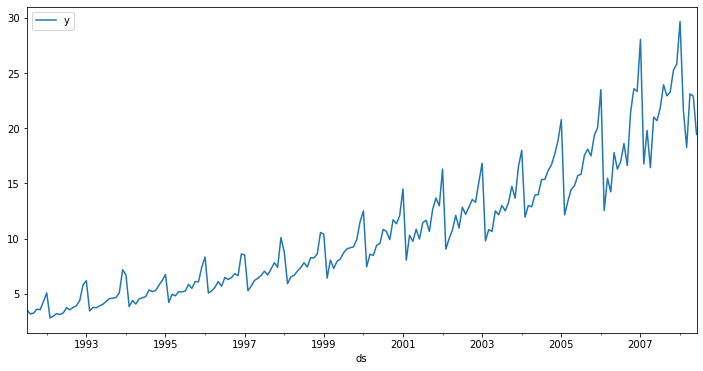

In [8]:
# Plotting Data:

df.plot(figsize= (12,6))

### ETS Decomposition:

In [9]:
decomp = seasonal_decompose(df["y"], model= "multiplicative")

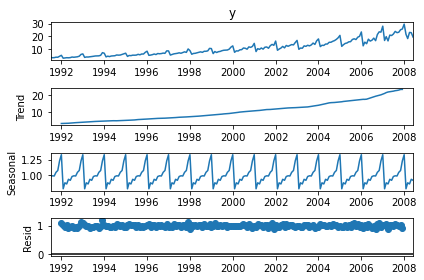

In [10]:
decomp.plot();

### Stationarity Check:

In [13]:
dickey_fuller_result(df["y"])

Test Statistics          3.145186
p-Value                  1.000000
No. of Lags             15.000000
No. of Observations    188.000000
Critical Value 1%       -3.465620
Critical Value 5%       -2.877040
Critical Value 10%      -2.575032
dtype: float64


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [75]:
# Series is Non-Stationary.

# We have to apply Differencing.

In [14]:
df["diff_1"] = diff(df["y"], k_diff= 1)

In [15]:
df.head()

,y,diff_1
ds,,
1991-07-01,3.526591,NaN
1991-08-01,3.180891,-0.345700
1991-09-01,3.252221,0.071330
1991-10-01,3.611003,0.358782
1991-11-01,3.565869,-0.045134


In [16]:
# Checking Stationarity of First Order Differenced Data:

dickey_fuller_result(df["diff_1"])

Test Statistics         -2.495172
p-Value                  0.116653
No. of Lags             15.000000
No. of Observations    187.000000
Critical Value 1%       -3.465812
Critical Value 5%       -2.877123
Critical Value 10%      -2.575077
dtype: float64


Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [17]:
# Applying Second Order Differencing:

df["diff_2"] = diff(df["y"], k_diff= 2)

In [18]:
df.head()

,y,diff_1,diff_2
ds,,,
1991-07-01,3.526591,NaN,NaN
1991-08-01,3.180891,-0.345700,NaN
1991-09-01,3.252221,0.071330,0.417030
1991-10-01,3.611003,0.358782,0.287452
1991-11-01,3.565869,-0.045134,-0.403916


In [19]:
# Checking Stationarity of Second Order Differenced Data:

dickey_fuller_result(df["diff_2"])

Test Statistics       -1.029230e+01
p-Value                3.543916e-18
No. of Lags            1.400000e+01
No. of Observations    1.870000e+02
Critical Value 1%     -3.465812e+00
Critical Value 5%     -2.877123e+00
Critical Value 10%    -2.575077e+00
dtype: float64


Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### ACF and PACF Plots:

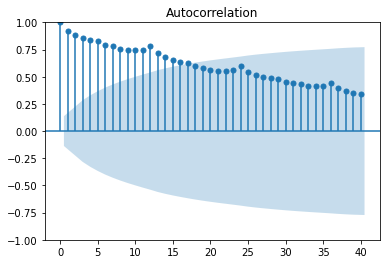

In [20]:
plot_acf(df["y"], lags= 40);

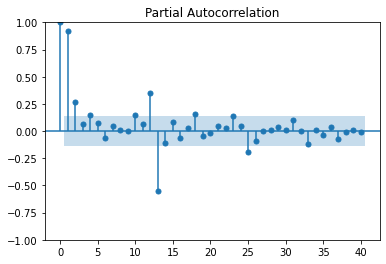

In [21]:
plot_pacf(df["y"], lags= 40, method= "ywm");

### Using Auto ARIMA to Decide Orders:

In [22]:
grid_arima = auto_arima(df["y"], seasonal= True, m= 12, trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=526.837, Time=0.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=659.245, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=560.558, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=529.539, Time=0.14 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=525.356, Time=0.51 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=551.838, Time=0.16 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=526.365, Time=0.92 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=530.219, Time=0.42 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=527.568, Time=0.39 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=529.582, Time=0.31 sec
 ARIMA(3,1,2)(0,1,1)[12]             : AIC=520.313, Time=0.40 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=544.911, Time=0.19 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=521.966, Time=0.58 sec
 ARIMA(3,1,2)(0,1,2)[12]             

In [23]:
grid_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -252.988
Date:                            Thu, 24 Nov 2022   AIC                            519.977
Time:                                    17:19:00   BIC                            542.743
Sample:                                07-01-1991   HQIC                           529.198
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2112      0.126     -1.683      0.092      -0.457       0.035
ar.L2          0.1221      0.120      1.018      0.309      -0.113       0.357
ar.L3          0.1174      0.090      1.311      0.190      -0.058       0.293
ar.L4         -0.2340      0.077     -3.021      0.003      -0.386      -0.082
ma.L1         -0.7149      0.113     -6.315      0.000      -0.937      -0.493
ma.S.L12      -0.4786      0.063     -7.613      0.000      -0.602      -0.355
sigma2         0.8086      0.053     15.389      0.000       0.706       0.912
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               176.72
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              15.18   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# So, (p,d,q) = (4,1,1) for ARIMA
# (P,D,Q,m) = (0,1,1,12) for SARIMA

### Train Test Split:

In [25]:
len(df)

204

In [26]:
train_data = df[:180]
test_data = df[180:]

In [27]:
train_data.shape

(180, 3)

In [28]:
test_data.shape

(24, 3)

### 1) ARIMA(4,1,1) Model:

In [29]:
arima_model = ARIMA(train_data["y"], order= (4,1,1))

In [30]:
arima_result = arima_model.fit()

In [31]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  180
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -342.643
Date:                Thu, 24 Nov 2022   AIC                            697.286
Time:                        17:20:25   BIC                            716.410
Sample:                    07-01-1991   HQIC                           705.040
                         - 06-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2510      0.210      1.196      0.232      -0.160       0.663
ar.L2          0.0379      0.157      0.241      0.809      -0.270       0.345
ar.L3         -0.1094      0.153     -0.713      0.476      -0.410       0.191
ar.L4         -0.0339      0.158     -0.214      0.830      -0.344       0.276
ma.L1         -0.8189      0.164     -4.980      0.000      -1.141      -0.497
sigma2         2.6794      0.211     12.715      0.000       2.266       3.092
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               188.78
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               7.20   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Predictions on Test Data:

start = len(train_data)
end = len(train_data) + len(test_data) -1

arima_pred = arima_result.predict(start= start, end= end, typ= "levels")

In [33]:
arima_pred

2006-07-01    17.028135
2006-08-01    16.810155
2006-09-01    16.826006
2006-10-01    16.791780
2006-11-01    16.782637
2006-12-01    16.784709
2007-01-01    16.788089
2007-02-01    16.791177
2007-03-01    16.792164
2007-04-01    16.792089
2007-05-01    16.791655
2007-06-01    16.791330
2007-07-01    16.791207
2007-08-01    16.791214
2007-09-01    16.791261
2007-10-01    16.791298
2007-11-01    16.791312
2007-12-01    16.791312
2008-01-01    16.791307
2008-02-01    16.791303
2008-03-01    16.791301
2008-04-01    16.791301
2008-05-01    16.791302
2008-06-01    16.791302
Freq: MS, Name: predicted_mean, dtype: float64

In [96]:
test_data["Thousands of Passengers"]

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Thousands of Passengers, dtype: int64

<AxesSubplot:xlabel='ds'>

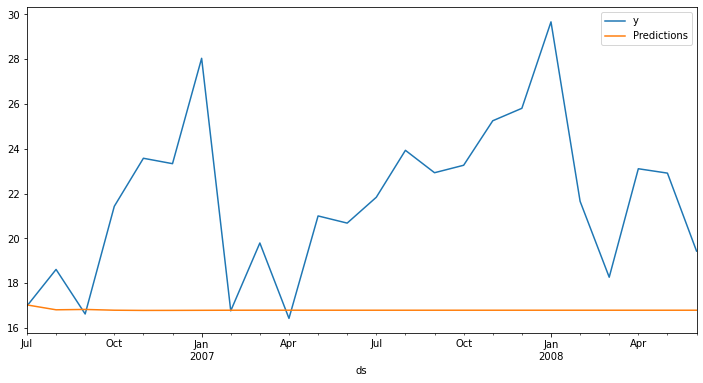

In [34]:
# Plotting Test Data and Predictions:

test_data["y"].plot(figsize= (12,6), legend= True)
arima_pred.plot(label= "Predictions", legend= True)

In [35]:
# Model Evaluation:

np.sqrt(mean_squared_error(test_data["y"], arima_pred))

6.010728335229532

In [36]:
# Training Model and Full Data and Making Predictions for Future:

final_arima = ARIMA(df["y"], order= (4,1,1))

In [37]:
arima_result = final_arima.fit()

In [38]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -423.320
Date:                Thu, 24 Nov 2022   AIC                            858.640
Time:                        17:21:05   BIC                            878.519
Sample:                    07-01-1991   HQIC                           866.682
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2607      0.111      2.347      0.019       0.043       0.478
ar.L2          0.0711      0.106      0.670      0.503      -0.137       0.279
ar.L3         -0.0886      0.081     -1.095      0.273      -0.247       0.070
ar.L4         -0.0571      0.102     -0.561      0.575      -0.257       0.142
ma.L1         -0.8071      0.098     -8.269      0.000      -0.998      -0.616
sigma2         3.7771      0.271     13.943      0.000       3.246       4.308
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               121.81
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               9.58   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# Forecasting:

forecast_arima = arima_result.predict(start= len(df), end= len(df)+23, typ= "levels")

In [40]:
forecast_arima

2008-07-01    21.591963
2008-08-01    21.648360
2008-09-01    22.135952
2008-10-01    22.274584
2008-11-01    22.216978
2008-12-01    22.165414
2009-01-01    22.107752
2009-02-01    22.086240
2009-03-01    22.084392
2009-04-01    22.090433
2009-05-01    22.097075
2009-06-01    22.100628
2009-07-01    22.101597
2009-08-01    22.101169
2009-09-01    22.100432
2009-10-01    22.099921
2009-11-01    22.099717
2009-12-01    22.099718
2010-01-01    22.099791
2010-02-01    22.099857
2010-03-01    22.099891
2010-04-01    22.099898
2010-05-01    22.099893
2010-06-01    22.099885
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='ds'>

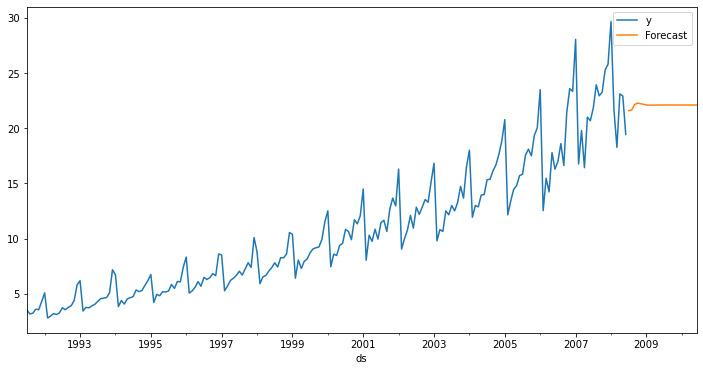

In [41]:
# Plotting Historic and Forecast Data:

df["y"].plot(figsize= (12,6), legend= True)
forecast_arima.plot(label= "Forecast", legend= True)

### 1) SARIMA(4,1,1)(0,1,1,12) Model:

In [42]:
sarima_model = SARIMAX(train_data["y"], order= (4,1,1), seasonal_order= (0,1,1,12))

In [43]:
sarima_result = sarima_model.fit()

In [44]:
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -155.478
Date:                            Thu, 24 Nov 2022   AIC                            324.956
Time:                                    17:22:04   BIC                            346.782
Sample:                                07-01-1991   HQIC                           333.815
                                     - 06-01-2006                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0223      0.090     -0.249      0.804      -0.199       0.154
ar.L2          0.3070      0.090      3.397      0.001       0.130       0.484
ar.L3          0.1187      0.082      1.447      0.148      -0.042       0.279
ar.L4          0.0229      0.087      0.263      0.793      -0.148       0.194
ma.L1         -0.9355      0.048    -19.514      0.000      -1.030      -0.842
ma.S.L12      -0.2246      0.072     -3.127      0.002      -0.365      -0.084
sigma2         0.3718      0.038      9.902      0.000       0.298       0.445
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.27
Prob(Q):                              0.82   Prob(JB):                         0.02
Heteroskedasticity (H):               4.72   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Predictions on Test Data:

start = len(train_data)
end = len(train_data) + len(test_data) -1

sarima_pred = sarima_result.predict(start= start, end= end, typ= "levels")

In [46]:
sarima_pred

2006-07-01    17.734359
2006-08-01    18.672058
2006-09-01    19.406632
2006-10-01    19.056435
2006-11-01    20.639147
2006-12-01    21.504622
2007-01-01    24.603230
2007-02-01    14.294180
2007-03-01    16.838344
2007-04-01    16.061842
2007-05-01    18.934102
2007-06-01    17.932605
2007-07-01    19.137865
2007-08-01    20.161387
2007-09-01    20.863768
2007-10-01    20.523672
2007-11-01    22.101021
2007-12-01    22.967862
2008-01-01    26.065255
2008-02-01    15.756246
2008-03-01    18.300075
2008-04-01    17.523480
2008-05-01    20.395617
2008-06-01    19.394055
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='ds'>

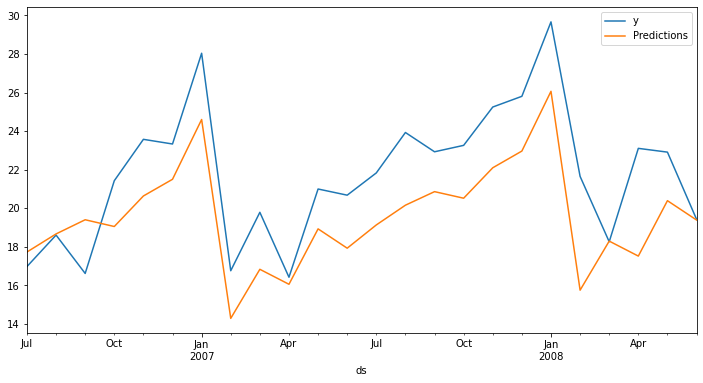

In [47]:
# Plotting Test Data and Predictions:

test_data["y"].plot(figsize= (12,6), legend= True)
sarima_pred.plot(label= "Predictions", legend= True)

In [48]:
# Model Evaluation:

np.sqrt(mean_squared_error(test_data["y"], sarima_pred))

2.8939915170007615

In [49]:
# Training Model and Full Data and Making Predictions for Future:

final_sarima = SARIMAX(df["y"], order= (4,1,1), seasonal_order= (0,1,1,12))

In [50]:
sarima_result = final_sarima.fit()

In [51]:
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(4, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -252.988
Date:                            Thu, 24 Nov 2022   AIC                            519.977
Time:                                    17:22:59   BIC                            542.743
Sample:                                07-01-1991   HQIC                           529.198
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2112      0.126     -1.683      0.092      -0.457       0.035
ar.L2          0.1221      0.120      1.018      0.309      -0.113       0.357
ar.L3          0.1174      0.090      1.311      0.190      -0.058       0.293
ar.L4         -0.2340      0.077     -3.021      0.003      -0.386      -0.082
ma.L1         -0.7149      0.113     -6.315      0.000      -0.937      -0.493
ma.S.L12      -0.4786      0.063     -7.613      0.000      -0.602      -0.355
sigma2         0.8086      0.053     15.389      0.000       0.706       0.912
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               176.72
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              15.18   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# Forecasting:

forecast_sarima = sarima_result.predict(start= len(df), end= len(df)+11, typ= "levels")

In [53]:
forecast_sarima

2008-07-01    25.178308
2008-08-01    23.462209
2008-09-01    24.380651
2008-10-01    26.256824
2008-11-01    26.669773
2008-12-01    28.520022
2009-01-01    31.493809
2009-02-01    22.432402
2009-03-01    22.275408
2009-04-01    23.383562
2009-05-01    25.282773
2009-06-01    23.144847
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='ds'>

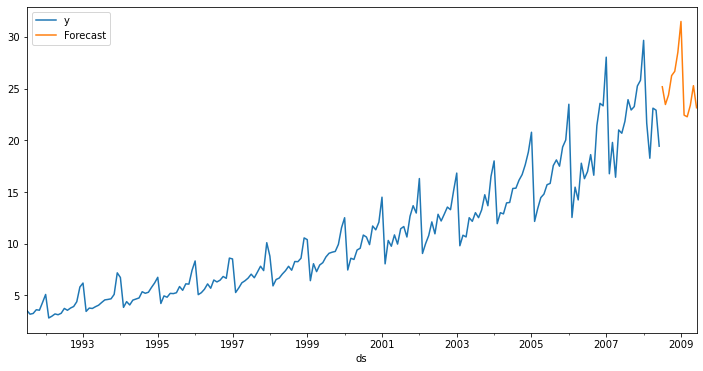

In [55]:
# Plotting Historic and Forecast Data:

df["y"].plot(figsize= (12,6), legend= True)
forecast_sarima.plot(label= "Forecast", legend= True)

### Comparing Predictions and Forecast of ARIMA and SARIMA:

<AxesSubplot:xlabel='ds'>

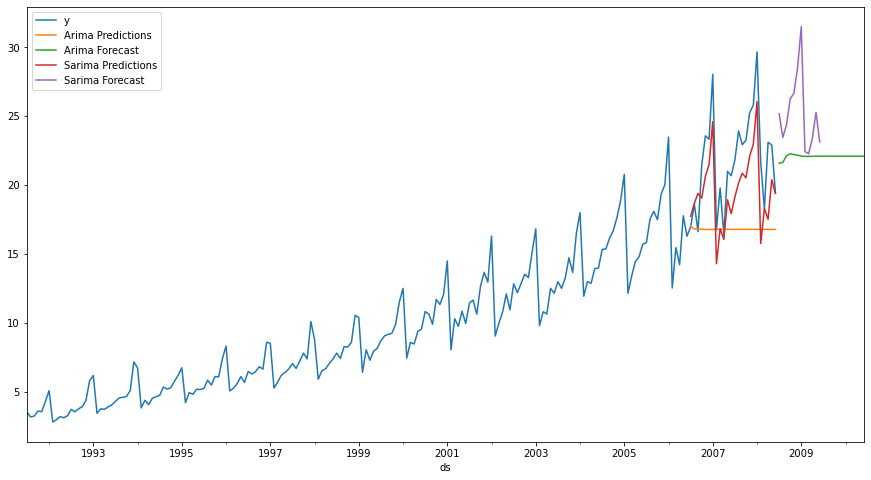

In [56]:
df["y"].plot(figsize= (15,8), legend= True)

arima_pred.plot(label= "Arima Predictions", legend= True)
forecast_arima.plot(label= "Arima Forecast", legend= True)

sarima_pred.plot(label= "Sarima Predictions", legend= True)
forecast_sarima.plot(label= "Sarima Forecast", legend= True)